Understanding of Problem statement :-

In any of the IT industry, incident management plays an important role in delivering quality and timely support to its customers across the globe.

Incident tickets gets raised by various groups of people belonging to different domains within the organization to resolve an issue as quickly as possible(within the SLA defined) based on it's severity

L1 / L2 needs to spend time to review Standard Operating Procedures (SOPs) before assigning to Functional teams (Minimum 25–30% of incidents needs to be reviewed for SOPs before ticket assignment).

15 min is being spent for SOP review for each incident.
Minimum of 1 FTE effort needed only for incident assignment to L3 teams.

During the process of incident assignments by L1 / L2 teams to functional groups, there were multiple instances of incidents getting assigned to wrong functional groups. 

Around 25% of Incidents are wrongly assigned to functional teams.
Additional effort needed for Functional teams to re-assign to right functional groups

During this process, some of the incidents are in queue and not addressed timely resulting in poor customer service and loss of business.

Objective:-

Design AI solution that can classify incidents to the right functional groups by implementing best suited machine learning model that can be operationalized within an organization for improving customer satisfaction.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly as py
from plotly.offline import iplot
import cufflinks as cf

In [2]:
incident_df = pd.read_excel("/content/drive/MyDrive/Capstone/input_data.xlsx")

In [3]:
#Checking for first few records

incident_df.head()

Short description  ... Assignment group
0                    login issue  ...            GRP_0
1                        outlook  ...            GRP_0
2             cant log in to vpn  ...            GRP_0
3  unable to access hr_tool page  ...            GRP_0
4                   skype error   ...            GRP_0

[5 rows x 4 columns]

In [4]:
#Let's check for null values in the dataset
incident_df.isnull().sum()

Short description    8
Description          1
Caller               0
Assignment group     0
dtype: int64

In [5]:
#Replacing null values in Short description and Description columns
incident_df['Short description'] = incident_df['Short description'].replace(np.nan, '',regex=True)
incident_df['Description'] = incident_df['Description'].replace(np.nan, '',regex=True)

In [6]:
#Validating that no more nulls exist in the dataset
incident_df.isnull().sum()

Short description    0
Description          0
Caller               0
Assignment group     0
dtype: int64

In [7]:
!pip install sweetviz

     |████████████████████████████████| 15.1MB 233kB/s 
     |████████████████████████████████| 81kB 8.8MB/s 
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


In [8]:
!pip install pandas-profiling==2.7.1

     |████████████████████████████████| 256kB 2.9MB/s 
     |████████████████████████████████| 61kB 5.9MB/s 
     |████████████████████████████████| 3.1MB 12.4MB/s 
     |████████████████████████████████| 1.1MB 21.1MB/s 
     |████████████████████████████████| 296kB 27.6MB/s 
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp37-none-any.whl size=27085 sha256=3ac70d8299b8f86a912088d630353b26d6c4e368eacc75dff1e2e62bec82cd3a
  Stored in directory: /root/.cache/pip/wheels/43/07/ac/7c5a9d708d65247ac1f94066cf1db075540b85716c30255459
  Created wheel for phik: filename=phik-0.11.2-cp37-none-any.whl size=1107413 sha256=5fb7ef5a4825066d0168dcc2a657a8aa34697ae11d1b60351e861f693a6fbdde
  Stored in directory: /root/.cache/pip/wheels/c0/a3/b0/f27b1cfe32ea131a3715169132ff6d85653789e80e966c3bf6
Successfully built htmlmin phik
ERROR: phik 0.11.2 has requirement scipy>=1.5.2, but you'll have scipy 1.4.1 which is incompatible.
  Found existing installation: pandas-profiling 1.4.1
    Uninstalling pa

In [10]:
import sweetviz as sz
import pandas_profiling
from pandas_profiling import ProfileReport

In [11]:
#Dropping the caller column as not finding it important for the classification task given
incident_df_updated = incident_df.drop('Caller',axis=1)

                                             |          | [  0%]   00:00 -> (? left)


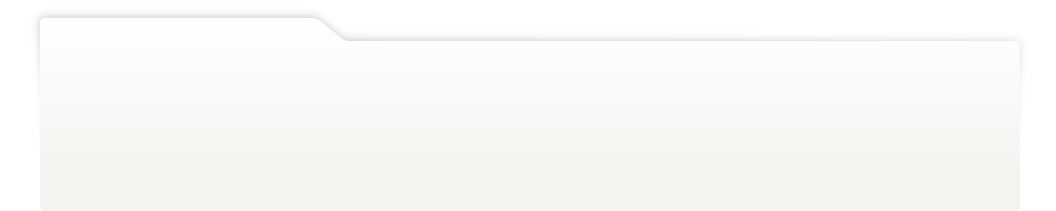
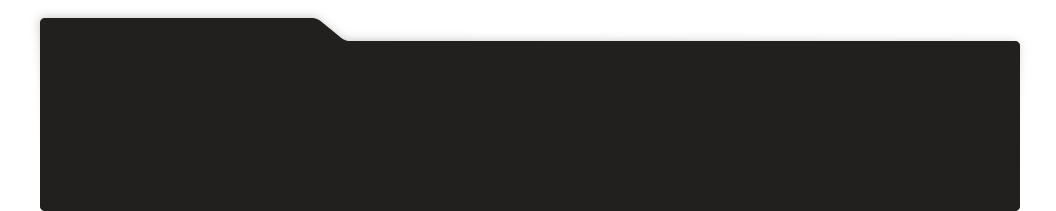
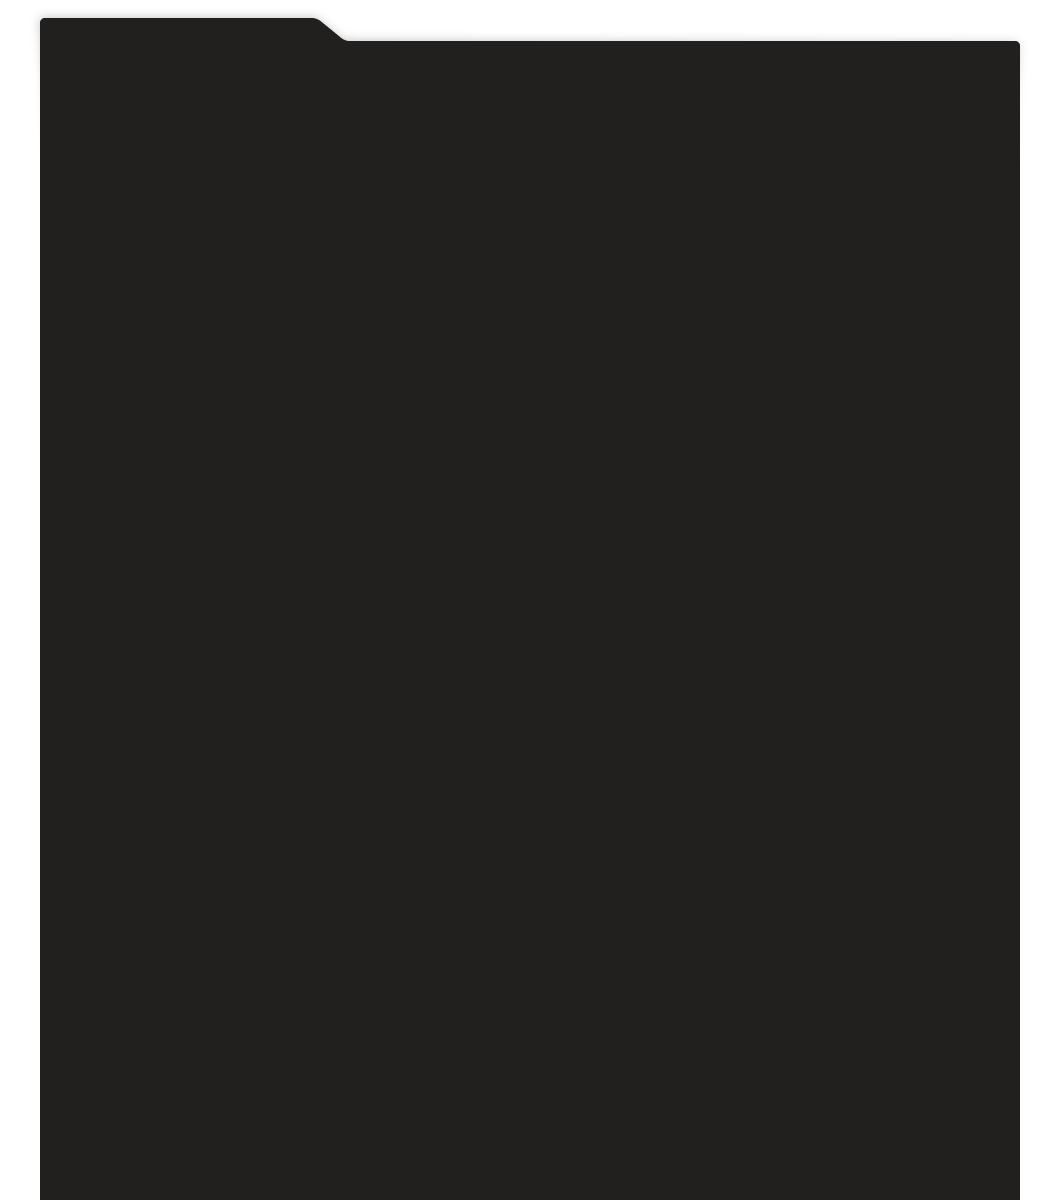
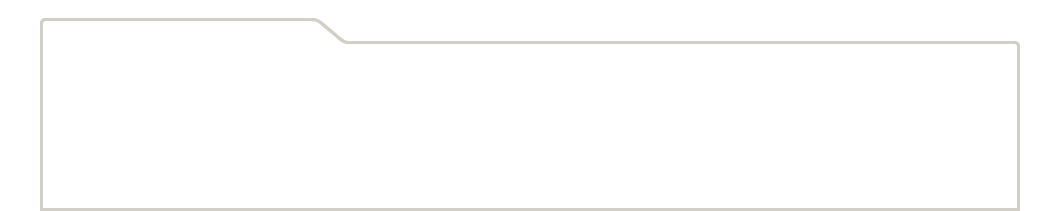
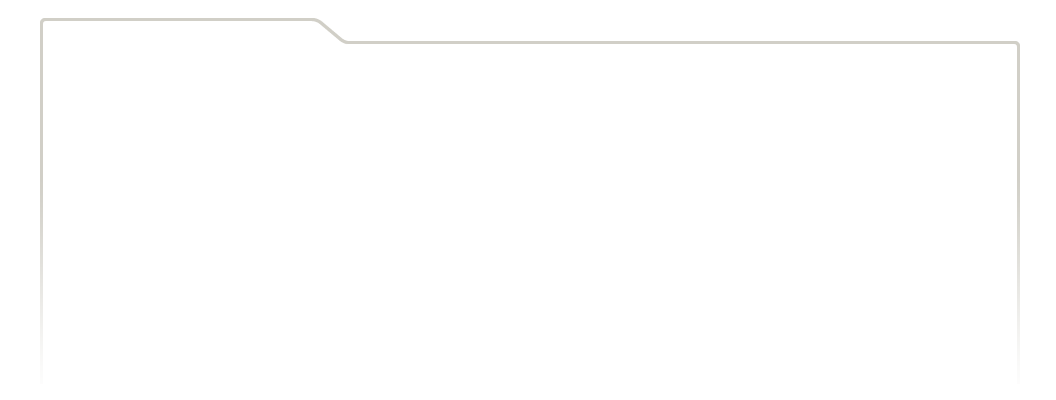
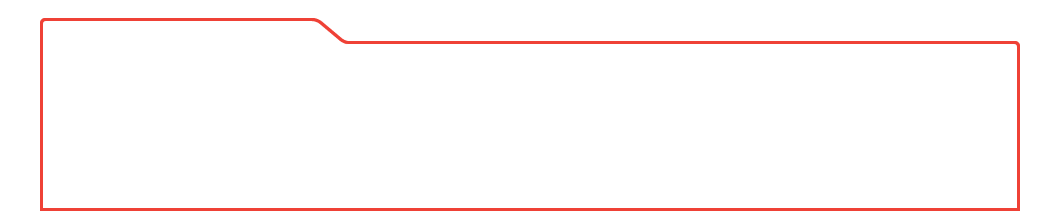
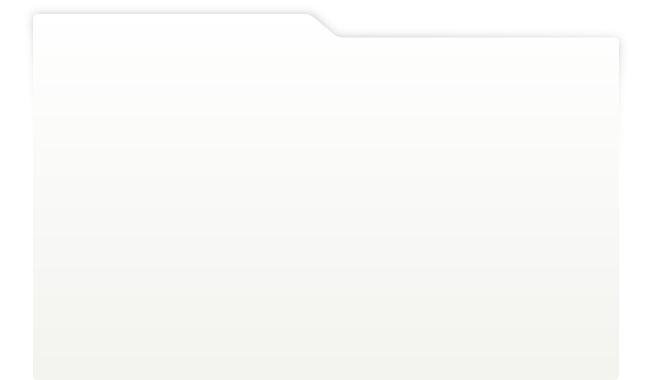
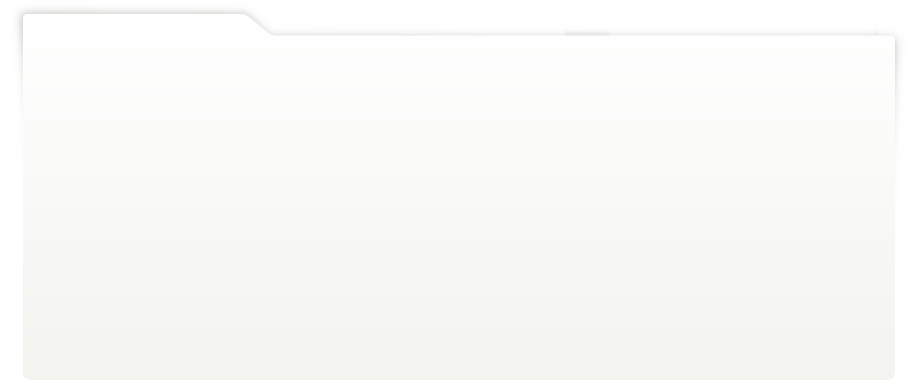
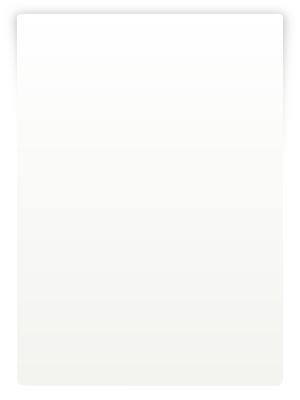
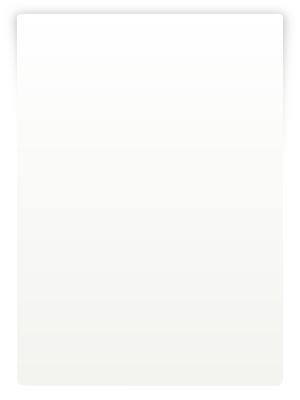
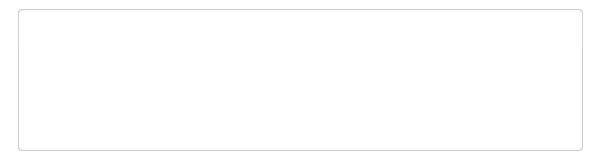
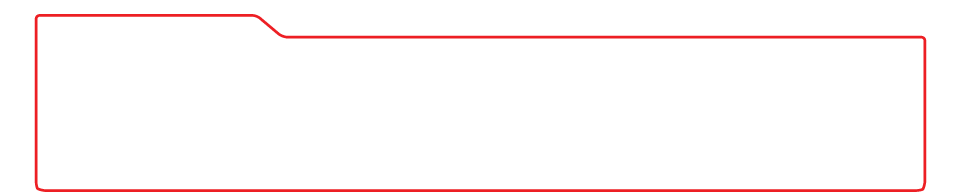
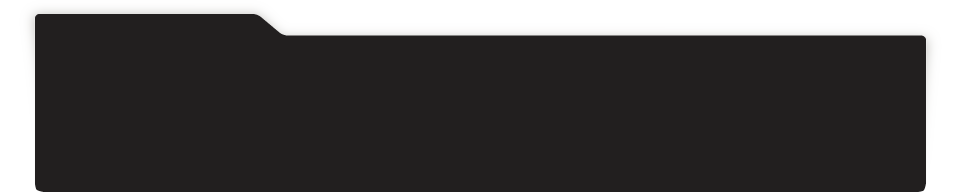
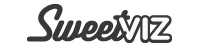
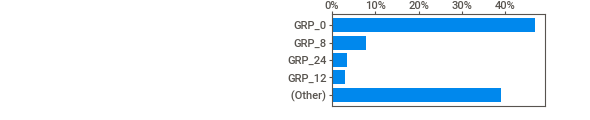
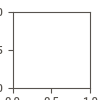

In [12]:
#Analyzing the dataset using sweetviz
incident_report = sz.analyze(incident_df_updated)
#Displaying the report
incident_report.show_notebook(layout='vertical', w= 1000, h=700, scale = 1.0)

In [13]:
incident_profile = ProfileReport(incident_df_updated)
incident_profile

Summarize dataset:   0%|          | 0/15 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#Observations from the above EDA report:-

1. There are total of 8500 rows and 3 features( 2 texts and 1 categorical)
2. Out of 8500 rows, 591 rows are duplicate entries
3. For "Short description" feature 88% are distinct values & 12% are duplicates.
4. Most frequent word/description for "Short description" feature is "Other" which comprises of 98% and rest are 2 %.
5. For "Description" feature, 92% are distinct values & 8% are duplicates.
6. Most frequent word/description for "Description" feature is "Other" which comprises of 98% and rest are 2 %.
7. There are total of 74 Assignment groups in the dataset which are unique values.No missing values exist.
8. Around 47% (close to 50% of the data) of the tickets belongs to GRP_0 and rest belongs to other groups which indicates that the Assignment group categorical feature is highly skewed/imbalanced.
9. This indicates we can merge few assignment groups with smaller percentage to reduce overall number of categories.

10. Also from the sample values we can see that description provided is also in German language other than English. Need to use google translator to convert those description text into English.

11. We can merge "Short description" and "Description" into 1 single feature.

12. There are emailids mentioned in the text for "Description". This needs to be taken care of while pre-processing the text.

13. Also there are some unreadable texts in the dataset which needs to be removed as part of preprocessing.



In [14]:
#Lets check the distribution of Assignment group column
incident_df_updated['Assignment group'].value_counts()

GRP_0     3976
GRP_8      661
GRP_24     289
GRP_12     257
GRP_9      252
          ... 
GRP_67       1
GRP_35       1
GRP_73       1
GRP_70       1
GRP_64       1
Name: Assignment group, Length: 74, dtype: int64

There are few groups in the dataset which has just 1 ticket assigned. All these smaller groups can be merged into a single group.

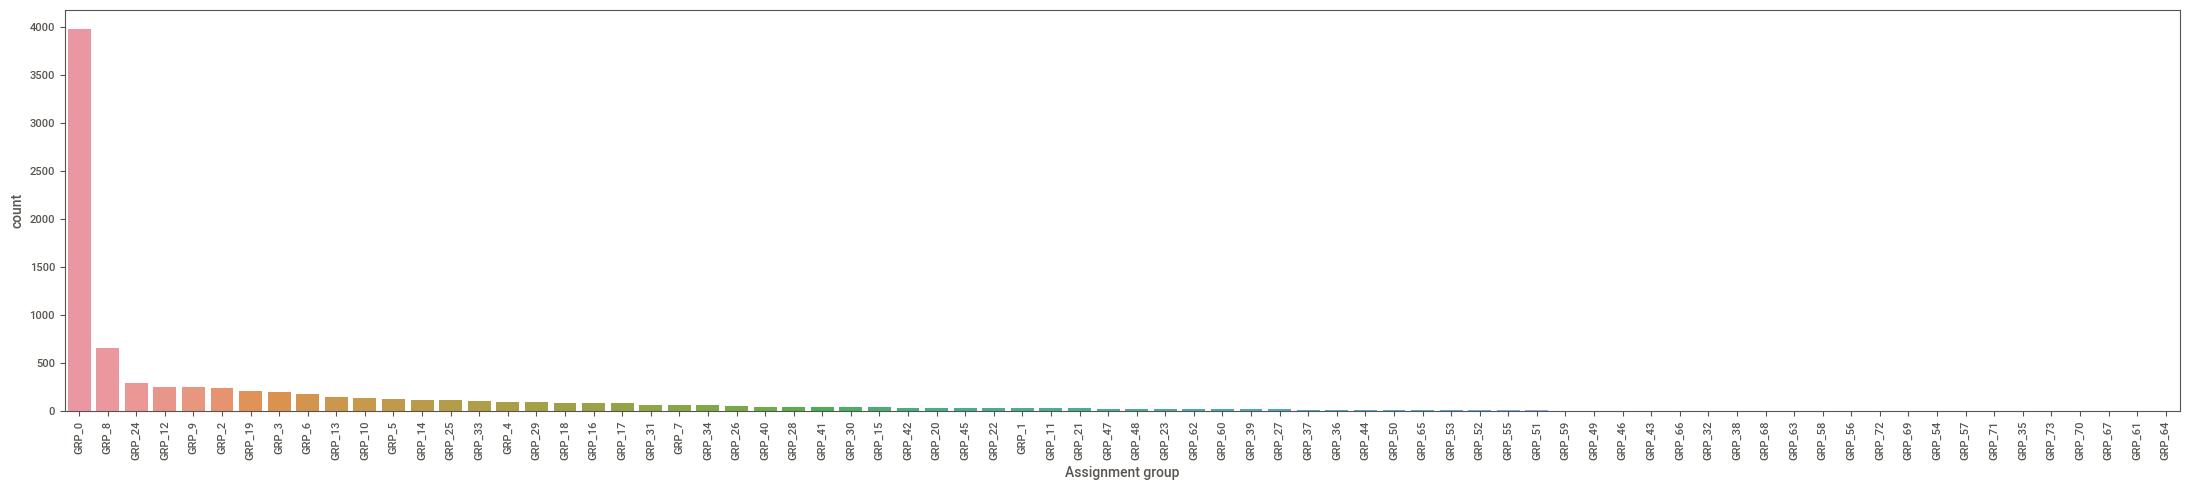

In [15]:
#Visualizing imbalance in the target class to find what all are smallest groups that can be merged to reduce total number of classification classes.
plt.figure(figsize=(22,5))
sortOrder = incident_df_updated['Assignment group'].value_counts().sort_values(ascending=False).index
ax = sns.countplot(x='Assignment group', data=incident_df_updated,order=sortOrder)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()
plt.show()

From the above graph, we can say that GRP_0 AND GRP_8 has maximum tickets assinged followd by GRP_24, GRP_12, GRP_9, GRP_2 AND GRP_19.

Other group seems to have less number of tickets assigned

In [16]:
#Lets find out the groups which has less than or equal to 30 tickets assigned

ticket_selected_grp = incident_df_updated.groupby(['Assignment group']).filter(lambda x: len(x) <=30)
print("No of Assignment groups with less than or equal to 30 tickets", ticket_selected_grp['Assignment group'].nunique())

No of Assignment groups with less than or equal to 30 tickets 40


From the above, it's clear that there are total 40 groups in the dataset with less than or equal to 30 tickets assigned.

Now let's understand distribution of other groups in the dataset other than GRP_0, GRP_8 and selected groups(<=30).

In [17]:
ticket_excluded_grp = ['GRP_0','GRP_8']
ticket_excluded_grp.extend(ticket_selected_grp['Assignment group'].unique())

ticket_excluded_grps = incident_df_updated[~incident_df_updated['Assignment group'].isin(ticket_excluded_grp)]

ticket_assigned_grp = pd.DataFrame(ticket_excluded_grps.groupby('Assignment group').size(),columns=['Count']).reset_index()

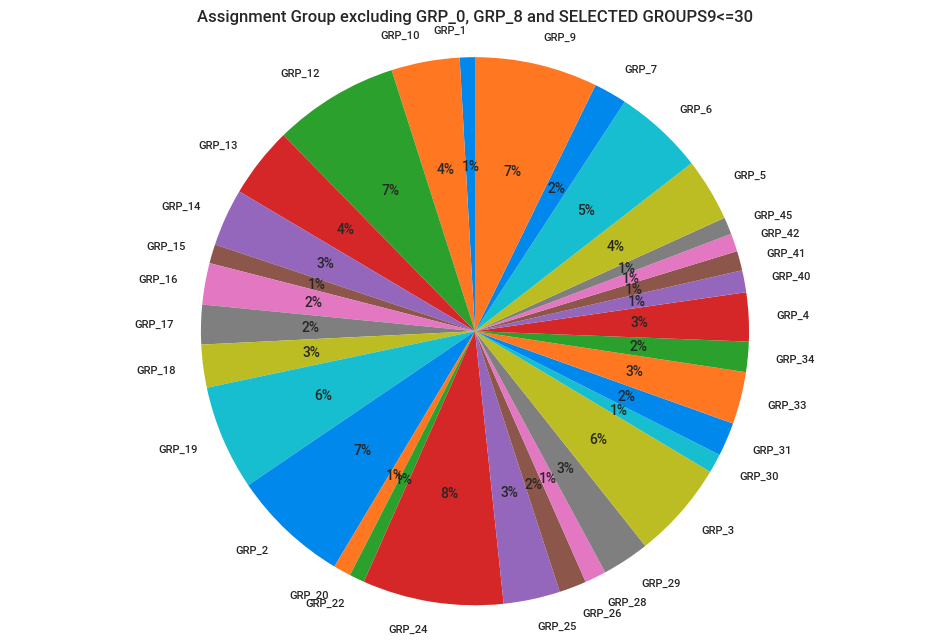

In [31]:
plt.figure(figsize=(12,8))
plt.pie(ticket_assigned_grp.Count,labels=ticket_assigned_grp['Assignment group'],autopct='%1.0f%%',startangle=90)
plt.title("Assignment Group excluding GRP_0, GRP_8 and SELECTED GROUPS9<=30")
plt.axis('equal')
plt.show()